In [130]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
import scikitplot as skplt
from sklearn.metrics import confusion_matrix

In [131]:
df = pd.read_csv('DATASET/MyDataset.csv')

In [132]:
df = df.drop(['login'], axis=1)

In [133]:
df = df.drop(['paymentType'], axis=1)

In [134]:
df.head()

,mounth,year,failCount,failPause,failMax,lifeTime,activeLife,calls,rejectedCalls,unansweredCalls,...,serviceTask,lk,bigFailure,sms,coefPrice,coefPayment,activeLifeM3,activeLifeM1,region,outflow
0,1,2021,0,0,0,152271259,152668800,3,0,1,...,2,0,0,3,915,0,2678400,2678400,0,0
1,1,2021,1,28354,28354,149668484,150076800,0,0,0,...,0,0,0,2,1190,1041,2678400,2678400,0,0
2,1,2021,1,28355,28355,146549163,136659459,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,2021,0,0,0,145585821,144806400,0,0,0,...,0,0,0,1,967,0,2678400,2678400,0,0
4,1,2021,1,28354,28354,144897376,126057600,0,0,0,...,0,0,0,1,744,0,1086683,1086683,0,1


In [135]:
# # Фильтруем строки с outflow = 0
# zero_outflow = df[df['outflow'] == 0]

# # Выбираем случайные 60% строк для удаления
# rows_to_delete = zero_outflow.sample(frac=0.6, random_state=0).index

# # Удаляем выбранные строки из оригинального DataFrame
# df = df.drop(rows_to_delete)

In [136]:
df.duplicated(keep=False).sum()

0

In [137]:
df.drop('outflow', axis=1).duplicated(keep=False).sum()

0

In [138]:
df = df.drop_duplicates()
df.head()

,mounth,year,failCount,failPause,failMax,lifeTime,activeLife,calls,rejectedCalls,unansweredCalls,...,serviceTask,lk,bigFailure,sms,coefPrice,coefPayment,activeLifeM3,activeLifeM1,region,outflow
1,1,2021,1,28354,28354,149668484,150076800,0,0,0,...,0,0,0,2,1190,1041,2678400,2678400,0,0
2,1,2021,1,28355,28355,146549163,136659459,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,2021,1,28354,28354,144897376,126057600,0,0,0,...,0,0,0,1,744,0,1086683,1086683,0,1
5,1,2021,1,28355,28355,141470047,65836800,0,0,0,...,0,0,0,1,967,0,301985,301985,0,1
7,1,2021,0,0,0,142222975,126489600,0,0,0,...,0,1,0,2,1184,1077,2678400,2678400,0,0


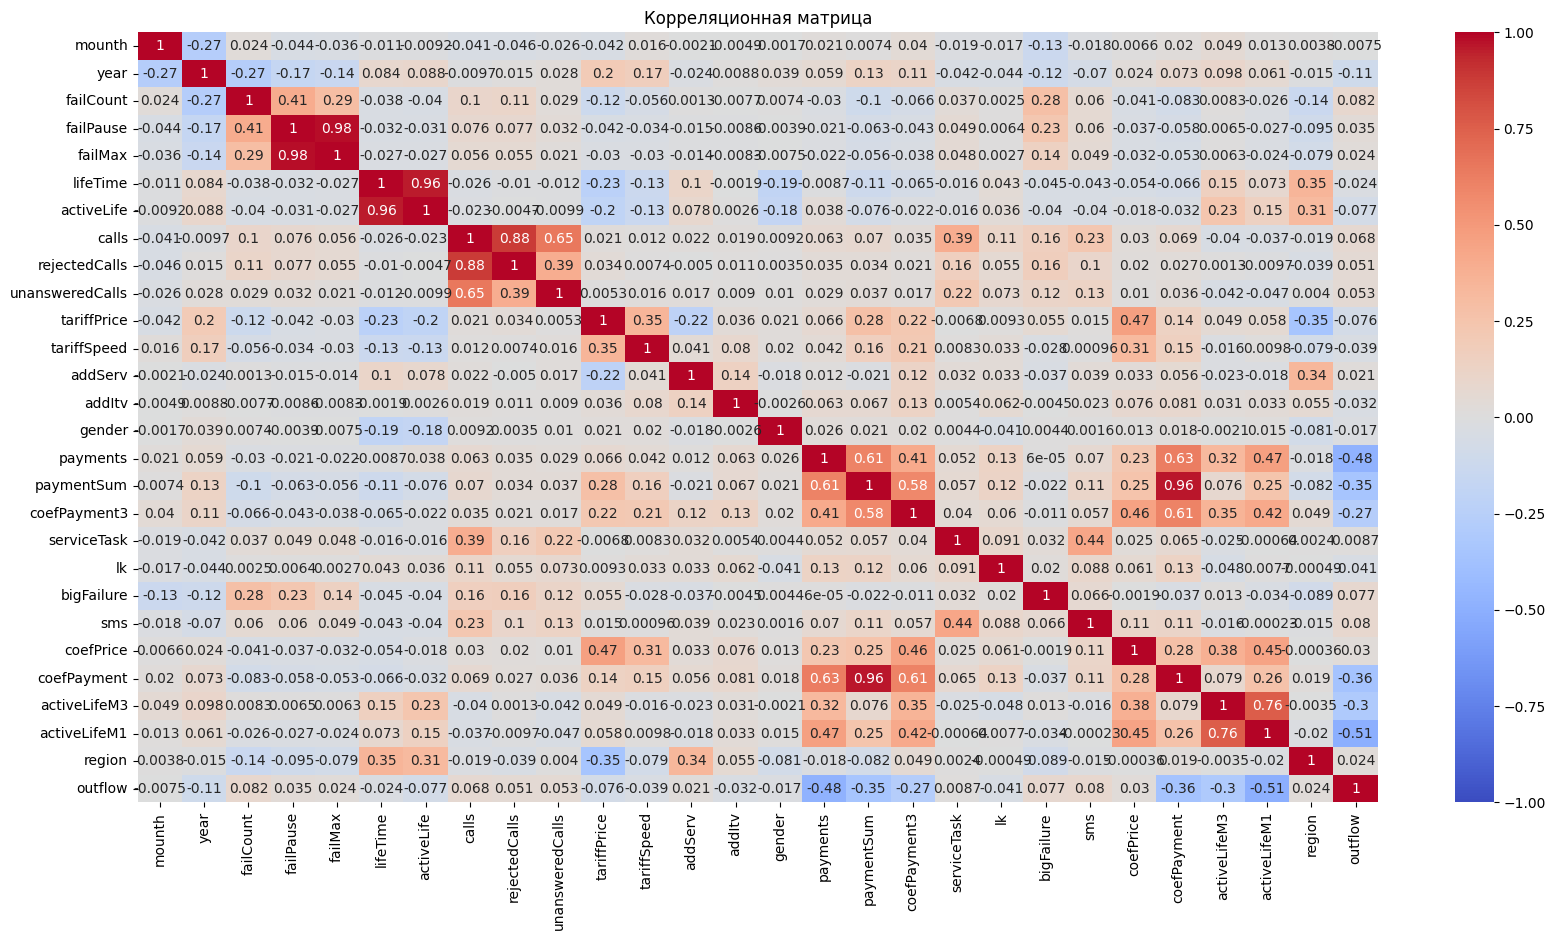

In [139]:
corr = df.corr()

# Построение тепловой карты
plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляционная матрица')
plt.show()

In [140]:
df = df[(df['mounth'] != 1) & (df['year'] != 2021)]

In [141]:
df['day'] = 1

In [142]:
df = df.rename(columns={"mounth": "month"})
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day']])

In [143]:
df['activeTime/lifeTime'] = df['activeLife'] / df['lifeTime']

df['failCount/activeLife'] = df['failCount'] / df['activeLife']

df['rejectedCalls/calls'] = np.where(df['calls'] == 0, 0, df['rejectedCalls'] / df['calls'])

df['unansweredCalls/calls'] = np.where(df['calls'] == 0, 0, df['unansweredCalls'] / df['calls'])

In [144]:
def normalize(group, columns):
    for col in columns:
        X_min = group[col].min()
        X_max = group[col].max()
        # Защита от деления на ноль
        range_span = X_max - X_min
        if range_span == 0:
            group[f'{col}_n'] = 0
        else:
            group[f'{col}_n'] = (group[col] - X_min) / range_span
    return group

# Укажите колонки для нормализации
# columns_to_normalize = ['paymentSum', 'tariffPrice', 'tariffSpeed']
columns_to_normalize = ['lifeTime', 'activeLife', 'tariffPrice', 'tariffSpeed', 'paymentSum', 'activeTime/lifeTime', 'failCount/activeLife', 'rejectedCalls/calls', 'unansweredCalls/calls']


# Применяем нормализацию по месяцам
df = df.groupby('datetime', group_keys=False).apply(normalize, columns=columns_to_normalize)

C:\Users\user\AppData\Local\Temp\ipykernel_10168\3554849816.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('datetime', group_keys=False).apply(normalize, columns=columns_to_normalize)


In [145]:
seconds_per_day = 86400 
days_per_year = 365.25 

# Конвертация секунд в годы
df['lifeTime_years'] = df['lifeTime'] / seconds_per_day // days_per_year

In [146]:
tmp = df.groupby("payments", as_index=False).agg({"outflow": ["sum", "count"]})
tmp["outflow (%)"] = 100 * tmp["outflow", "sum"] / tmp["outflow", "count"]
tmp.sort_values("outflow (%)").reset_index(drop=True)

payments outflow        outflow (%)
               sum  count            
0        4       0      6    0.000000
1        5       0      2    0.000000
2        6       0      2    0.000000
3       13       0      1    0.000000
4        1      96  10555    0.909522
5        2      13   1028    1.264591
6        3       2     95    2.105263
7        0    1235   2889   42.748356

In [147]:
tmp = df.groupby("bigFailure", as_index=False).agg({"outflow": ["sum", "count"]})
tmp["outflow (%)"] = 100 * tmp["outflow", "sum"] / tmp["outflow", "count"]
tmp.sort_values("outflow (%)").reset_index(drop=True)

bigFailure outflow        outflow (%)
                  sum  count            
0           7       0      6    0.000000
1           9       0      3    0.000000
2          14       1     46    2.173913
3          10       1     33    3.030303
4           5       8    126    6.349206
5           1      56    695    8.057554
6          12       5     62    8.064516
7           0    1231  13221    9.310945
8           4       8     81    9.876543
9           2      22    201   10.945274
10          6       2     16   12.500000
11          3       5     38   13.157895
12         18       7     50   14.000000

In [148]:
tmp = df.groupby("failCount", as_index=False).agg({"outflow": ["sum", "count"]})
tmp["outflow (%)"] = 100 * tmp["outflow", "sum"] / tmp["outflow", "count"]
tmp.sort_values("outflow (%)").reset_index(drop=True)

failCount outflow       outflow (%)
                 sum count            
0          7       0    11    0.000000
1          5       9   113    7.964602
2          0     655  7509    8.722866
3          1     341  3739    9.120086
4          2     183  1916    9.551148
5          3     109   983   11.088505
6         10       1     7   14.285714
7          6       5    33   15.151515
8          4      39   253   15.415020
9          9       1     5   20.000000
10         8       3     9   33.333333

In [149]:
df

,month,year,failCount,failPause,failMax,lifeTime,activeLife,calls,rejectedCalls,unansweredCalls,...,lifeTime_n,activeLife_n,tariffPrice_n,tariffSpeed_n,paymentSum_n,activeTime/lifeTime_n,failCount/activeLife_n,rejectedCalls/calls_n,unansweredCalls/calls_n,lifeTime_years
1391,2,2022,2,254248,176580,175407162,174200135,0,0,0,...,0.491159,0.496835,0.359322,0.331104,0.220000,0.639819,0.029263,0.0,0.0,5.0
1393,2,2022,1,176578,176578,176178175,160531200,1,1,0,...,0.493327,0.457694,0.698305,0.036789,0.420000,0.577415,0.015877,1.0,0.0,5.0
1396,2,2022,0,0,0,159674740,149990400,0,0,0,...,0.446932,0.427511,0.359322,0.331104,0.246000,0.598866,0.000000,0.0,0.0,5.0
1397,2,2022,0,0,0,156235483,63072000,0,0,0,...,0.437264,0.178624,0.257627,0.163880,0.160000,0.190883,0.000000,0.0,0.0,4.0
1398,2,2022,0,0,0,155966925,143729977,0,0,0,...,0.436509,0.409585,0.325424,0.080268,0.200000,0.585302,0.000000,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51073,4,2024,0,0,0,47174399,47174400,0,0,0,...,0.109385,0.115503,0.776398,0.099099,0.198006,0.961013,0.000000,0.0,0.0,1.0
51075,4,2024,0,0,0,45705599,45446400,0,0,0,...,0.105922,0.111209,0.664596,0.099099,0.156695,0.954920,0.000000,0.0,0.0,1.0
51077,4,2024,0,0,0,285587028,229432004,0,0,0,...,0.671468,0.568380,0.316770,0.099099,0.000000,0.749753,0.000000,0.0,0.0,9.0
51080,4,2024,0,0,0,284634155,277780254,0,0,0,...,0.669221,0.688517,0.316770,0.099099,0.092593,0.935142,0.000000,0.0,0.0,9.0


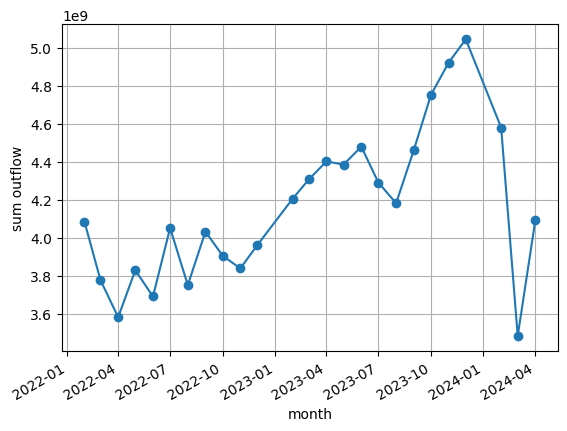

In [150]:
avg_price_per_year = df.groupby('datetime')['activeLifeM3'].sum()
avg_price_per_year.plot(kind='line', marker='o')
plt.xlabel('month')
plt.ylabel('sum outflow')
plt.grid(True)
plt.show()

In [151]:
df1 = df[df['year'] != 2024]
df2 = df[df['year'] == 2024]

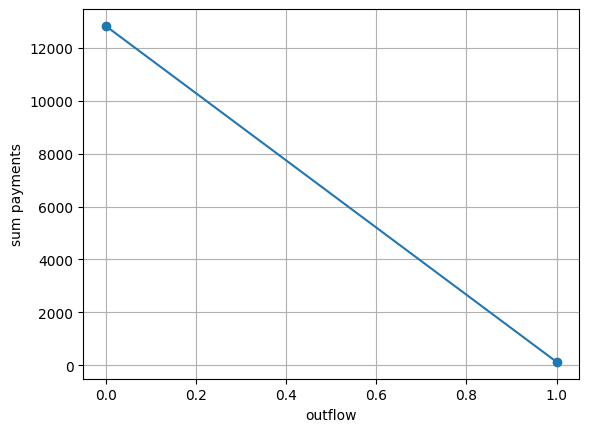

In [152]:
avg_price_per_year = df.groupby('outflow')['payments'].sum()
avg_price_per_year.plot(kind='line', marker='o')
plt.xlabel('outflow')
plt.ylabel('sum payments')
plt.grid(True)
plt.show()

In [153]:
df

,month,year,failCount,failPause,failMax,lifeTime,activeLife,calls,rejectedCalls,unansweredCalls,...,lifeTime_n,activeLife_n,tariffPrice_n,tariffSpeed_n,paymentSum_n,activeTime/lifeTime_n,failCount/activeLife_n,rejectedCalls/calls_n,unansweredCalls/calls_n,lifeTime_years
1391,2,2022,2,254248,176580,175407162,174200135,0,0,0,...,0.491159,0.496835,0.359322,0.331104,0.220000,0.639819,0.029263,0.0,0.0,5.0
1393,2,2022,1,176578,176578,176178175,160531200,1,1,0,...,0.493327,0.457694,0.698305,0.036789,0.420000,0.577415,0.015877,1.0,0.0,5.0
1396,2,2022,0,0,0,159674740,149990400,0,0,0,...,0.446932,0.427511,0.359322,0.331104,0.246000,0.598866,0.000000,0.0,0.0,5.0
1397,2,2022,0,0,0,156235483,63072000,0,0,0,...,0.437264,0.178624,0.257627,0.163880,0.160000,0.190883,0.000000,0.0,0.0,4.0
1398,2,2022,0,0,0,155966925,143729977,0,0,0,...,0.436509,0.409585,0.325424,0.080268,0.200000,0.585302,0.000000,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51073,4,2024,0,0,0,47174399,47174400,0,0,0,...,0.109385,0.115503,0.776398,0.099099,0.198006,0.961013,0.000000,0.0,0.0,1.0
51075,4,2024,0,0,0,45705599,45446400,0,0,0,...,0.105922,0.111209,0.664596,0.099099,0.156695,0.954920,0.000000,0.0,0.0,1.0
51077,4,2024,0,0,0,285587028,229432004,0,0,0,...,0.671468,0.568380,0.316770,0.099099,0.000000,0.749753,0.000000,0.0,0.0,9.0
51080,4,2024,0,0,0,284634155,277780254,0,0,0,...,0.669221,0.688517,0.316770,0.099099,0.092593,0.935142,0.000000,0.0,0.0,9.0


In [154]:
df1 = df[df['year'] != 2024]
df2 = df[df['year'] == 2024]

In [155]:
df1 = df1.drop(['year', 'datetime', 'day'], axis=1)
df2 = df2.drop(['year', 'datetime', 'day'], axis=1)

In [156]:
# X = df.drop('outflow', axis=1).values
# y = df['outflow'].values


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

In [157]:
X_train = df1.drop('outflow', axis=1)
X_test = df2.drop('outflow', axis=1)
y_train = df1['outflow']
y_test = df2['outflow']

In [158]:
train_data = Pool(X_train, y_train)
test_data = Pool(X_test, y_test)    

In [165]:
model = CatBoostClassifier(#class_weights=[1, 10],
                           auto_class_weights="SqrtBalanced",
                           learning_rate=0.01,
                           eval_metric='F1',
                        #    eval_metric="AUC:hints=skip_train~false",
                           iterations=5000,
                           l2_leaf_reg=10,
                           max_depth=2
                           ) 

model.fit(
    train_data, 
    eval_set=test_data)

0:	learn: 0.8653592	test: 0.0000000	best: 0.0000000 (0)	total: 5.97ms	remaining: 29.8s
1:	learn: 0.8607885	test: 0.0000000	best: 0.0000000 (0)	total: 10.1ms	remaining: 25.3s
2:	learn: 0.8748199	test: 0.0000000	best: 0.0000000 (0)	total: 15ms	remaining: 25s
3:	learn: 0.9239742	test: 0.0000000	best: 0.0000000 (0)	total: 19.7ms	remaining: 24.6s
4:	learn: 0.9280727	test: 0.0000000	best: 0.0000000 (0)	total: 24.2ms	remaining: 24.2s
5:	learn: 0.9137304	test: 0.0000000	best: 0.0000000 (0)	total: 27ms	remaining: 22.5s
6:	learn: 0.9280727	test: 0.0000000	best: 0.0000000 (0)	total: 30.3ms	remaining: 21.6s
7:	learn: 0.9266645	test: 0.0000000	best: 0.0000000 (0)	total: 33.4ms	remaining: 20.8s
8:	learn: 0.9276996	test: 0.0000000	best: 0.0000000 (0)	total: 36.7ms	remaining: 20.3s
9:	learn: 0.9266645	test: 0.0000000	best: 0.0000000 (0)	total: 40ms	remaining: 19.9s
10:	learn: 0.9278634	test: 0.0000000	best: 0.0000000 (0)	total: 43.3ms	remaining: 19.6s
11:	learn: 0.9283347	test: 0.0000000	best: 0.00000

Text(0.5, 1.0, 'Feature Importance')

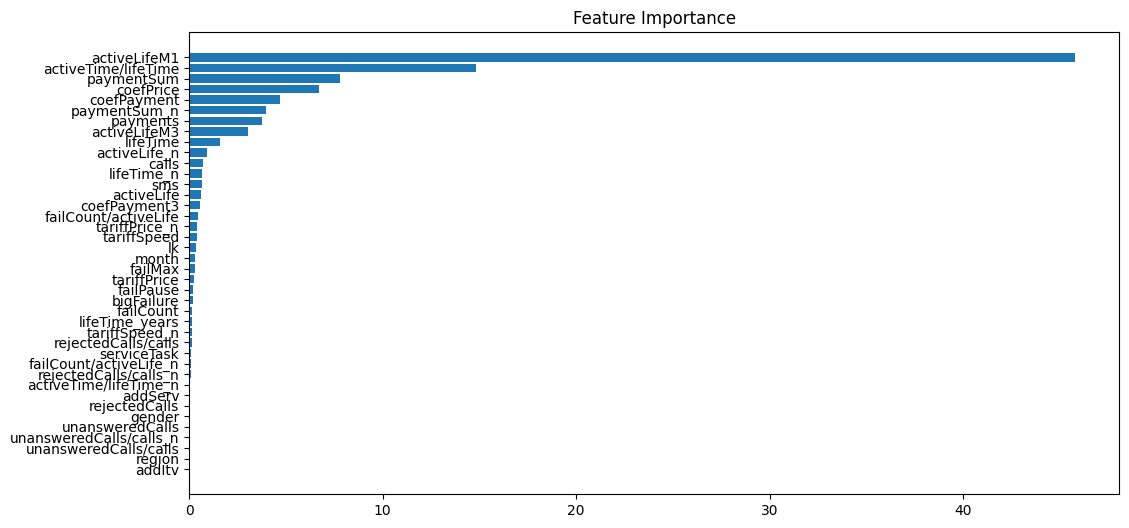

In [160]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance')

In [161]:
# threshold = 1

# # Определяем индексы фичей, которые имеют важность ниже порога
# low_importance_features = np.where(feature_importance < threshold)[0]

# low_importance_feature_names = X_train.columns[low_importance_features]

# df = df.drop(columns=low_importance_feature_names)


In [162]:
# Предсказание классов
predictions = model.predict(X_test)
print("Predicted classes:", predictions)

# Предсказание вероятностей
probabilities = model.predict_proba(X_test)
print("Predicted probabilities:", probabilities)

Predicted classes: [0 0 0 ... 0 0 0]
Predicted probabilities: [[7.99419666e-01 2.00580334e-01]
 [9.80295322e-01 1.97046781e-02]
 [9.99959927e-01 4.00730993e-05]
 ...
 [9.72600269e-01 2.73997309e-02]
 [9.99634654e-01 3.65345801e-04]
 [8.89104208e-01 1.10895792e-01]]


In [163]:
probabilities[:,1]

array([2.00580334e-01, 1.97046781e-02, 4.00730993e-05, ...,
       2.73997309e-02, 3.65345801e-04, 1.10895792e-01])

In [164]:
y_true = y_test
y_probas = probabilities
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

c:\Users\user\Desktop\LEO\ML_outflow_fridom\.venv\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\user\Desktop\LEO\ML_outflow_fridom\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


ValueError: Found input variables with inconsistent numbers of samples: [1648, 3296]

In [ ]:
# Задайте порог
threshold = 0.6

# Вероятности для класса 1
prob_class_1 = y_probas[:, 1]

# Прогнозы на основе порога
predictions = (prob_class_1 >= threshold).astype(int)

# Подсчитайте матрицу ошибок
tn, fp, fn, tp = confusion_matrix(y_true, predictions).ravel()

percent_true_positive = (tp / (tp + fn)) * 100
percent_false_positive = (fp / (fp + tn)) * 100

print('Всего 1:', sum(y_test))
print('Всего 0:', X_test['activeLife'].count())
print(f'Истинные положительные: {tp}')
print(f'Ложные положительные: {fp}')
print(f'Ложные отрицательные: {fn}')
print(f'Истинные отрицательные: {tn}')
print(f'Процент верно угаданных единиц: {percent_true_positive:.2f}%')
print(f'Процент нулей, предсказанных как единицы: {percent_false_positive:.2f}%')

Всего 1: 57
Всего 0: 2328
Истинные положительные: 49
Ложные положительные: 51
Ложные отрицательные: 8
Истинные отрицательные: 2220
Процент верно угаданных единиц: 85.96%
Процент нулей, предсказанных как единицы: 2.25%


In [ ]:
# Задайте процент допустимых ошибок в нулях
percent_error_allowed = 5

# Вероятности для класса 1
prob_class_1 = y_probas[:, 1]

total_zeros = sum(y_true == 0)

# Определите количество допустимых ошибок
allowed_errors = int(total_zeros * percent_error_allowed / 100)

sorted_prob_class_1 = np.sort(prob_class_1[y_true == 0])
threshold_for_error = sorted_prob_class_1[-allowed_errors] if allowed_errors > 0 else 1.0

predictions = (prob_class_1 >= threshold_for_error).astype(int)

tn, fp, fn, tp = confusion_matrix(y_true, predictions).ravel()

percent_true_positive = (tp / (tp + fn)) * 100
percent_false_positive = (fp / (fp + tn)) * 100

print('Всего 1:', sum(y_true))
print('Всего 0:', total_zeros)
print(f'Истинные положительные: {tp}')
print(f'Ложные положительные: {fp}')
print(f'Ложные отрицательные: {fn}')
print(f'Истинные отрицательные: {tn}')
print(f'Процент верно угаданных единиц: {percent_true_positive:.2f}%')
print(f'Процент нулей, предсказанных как единицы: {percent_false_positive:.2f}%')
print(f'Выбранный порог для ошибки в нулях: {threshold_for_error:.2f}')


Всего 1: 57
Всего 0: 2271
Истинные положительные: 53
Ложные положительные: 133
Ложные отрицательные: 4
Истинные отрицательные: 2138
Процент верно угаданных единиц: 92.98%
Процент нулей, предсказанных как единицы: 5.86%
Выбранный порог для ошибки в нулях: 0.46


In [ ]:
X_test['activeLife'].count()

2328